In [146]:
import geopandas as gp
import pandas as pd
import pylab as pl
import os
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['scatter']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD"
nrg = pd.read_csv(url)

bsize = gp.GeoDataFrame.from_file("../data/MNMapPLUTO.shp")

Energy Data - https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

Pluto Data - https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip

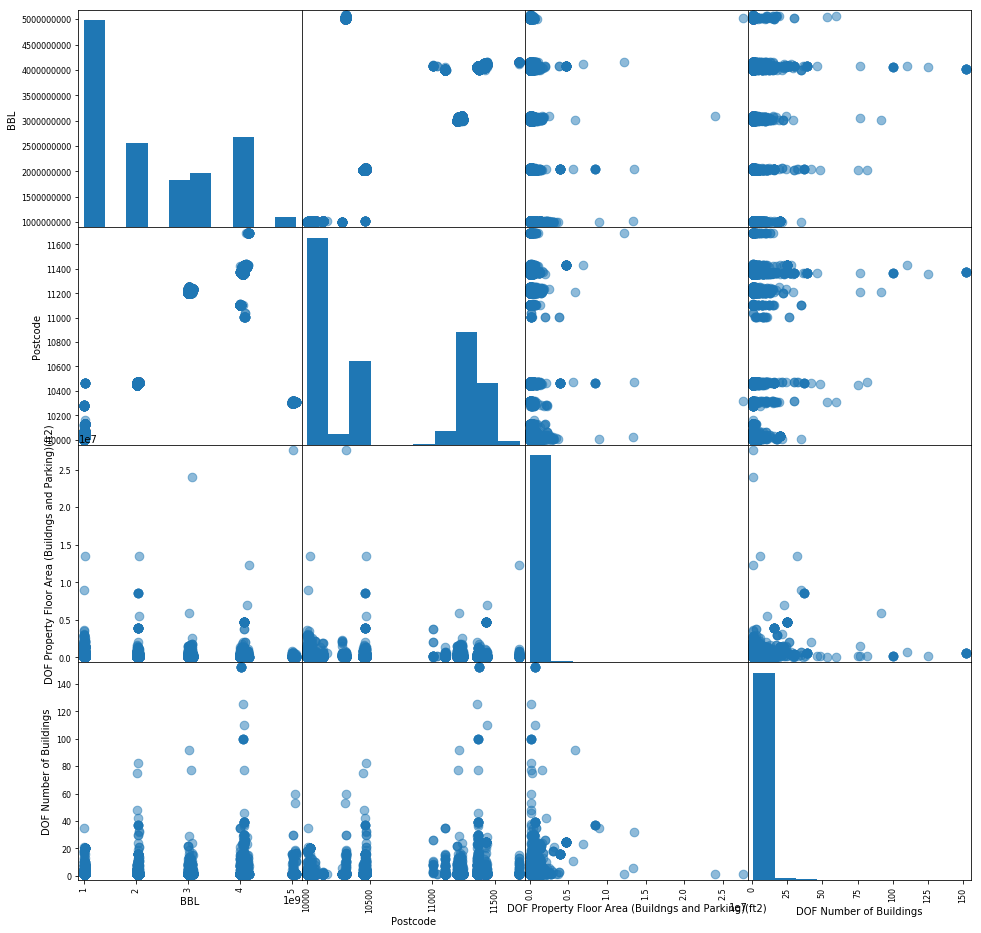

In [3]:
ADS = nrg[["BBL", "Postcode", "DOF Property Floor Area (Buildngs and Parking)(ft2)", "DOF Number of Buildings"]]

scatter_matrix (ADS, s=300, figsize=(16, 16));

### Figure 1:

Bi-variable visualization of key numerical variables.

In [4]:
for col in ADS:
    numNAN = np.isnan(ADS[col]).sum()
    print("Number of NAN in %s : %i (%.3f perc)" % (col, numNAN, numNAN*100 / len(ADS[col])))
    

Number of NAN in BBL : 156 (0.000 perc)
Number of NAN in Postcode : 1738 (10.000 perc)
Number of NAN in DOF Property Floor Area (Buildngs and Parking)(ft2) : 1705 (10.000 perc)
Number of NAN in DOF Number of Buildings : 1705 (10.000 perc)


In [5]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [47]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL')

In [56]:
keepCol = ["BBL", "Site EUI(kBtu/ft2)", "UnitsRes", "UnitsTotal", "YearBuilt", 
           "DOF Property Floor Area (Buildngs and Parking)(ft2)"]
bblnrgdata = bblnrgdata[keepCol]
bblnrgdata.columns = ["BBL", "energy_per_ft2", "UnitsRes", "UnitsTotal", "YearBuilt", "totalFloor_ft2"]

In [57]:
bblnrgdata = bblnrgdata.dropna()
bblnrgdata.shape

(4694, 6)

In [51]:
bblnrgdata.sample(10)

,BBL,Site EUI(kBtu/ft2),UnitsRes,UnitsTotal,YearBuilt,DOF Property Floor Area (Buildngs and Parking)(ft2)
2058,1.012330e+09,55.6,224,233,1931,352821.0
1069,1.008330e+09,90.8,0,9,1913,80185.0
4265,1.021790e+09,108.9,63,63,1920,57405.0
4137,1.021420e+09,96.5,57,64,1925,77877.0
4256,1.021790e+09,88.3,69,73,1920,70296.0
1144,1.008940e+09,68,0,145,1928,88463.0
778,1.007790e+09,55.5,0,57,1927,94914.0
2653,1.013710e+09,52.7,278,279,1958,510547.0
1528,1.009448e+09,86.2,118,119,1984,119913.0
2749,1.013880e+09,77.7,101,102,1975,74427.0


In [58]:
bblnrgdata["energy_per_ft2"] = pd.to_numeric(bblnrgdata["energy_per_ft2"], errors = "coerce").dropna()

In [59]:
bblnrgdata.sample(10)

,BBL,energy_per_ft2,UnitsRes,UnitsTotal,YearBuilt,totalFloor_ft2
618,1.006318e+09,121.2,73,74,1987,95573.0
1214,1.008590e+09,84.6,0,16,1913,126784.0
5080,1.020320e+09,125.7,196,198,1972,100421.0
3934,1.020580e+09,74.0,37,37,1925,55176.0
3079,1.014880e+09,85.6,210,224,1964,257244.0
3781,1.019610e+09,69.7,0,1,1970,422915.0
1584,1.010110e+09,229.4,68,69,1927,142283.0
627,1.006420e+09,39.5,121,121,1987,85030.0
2819,1.013990e+09,117.7,180,184,1968,246320.0
5372,1.012508e+09,104.8,54,54,1923,55190.0


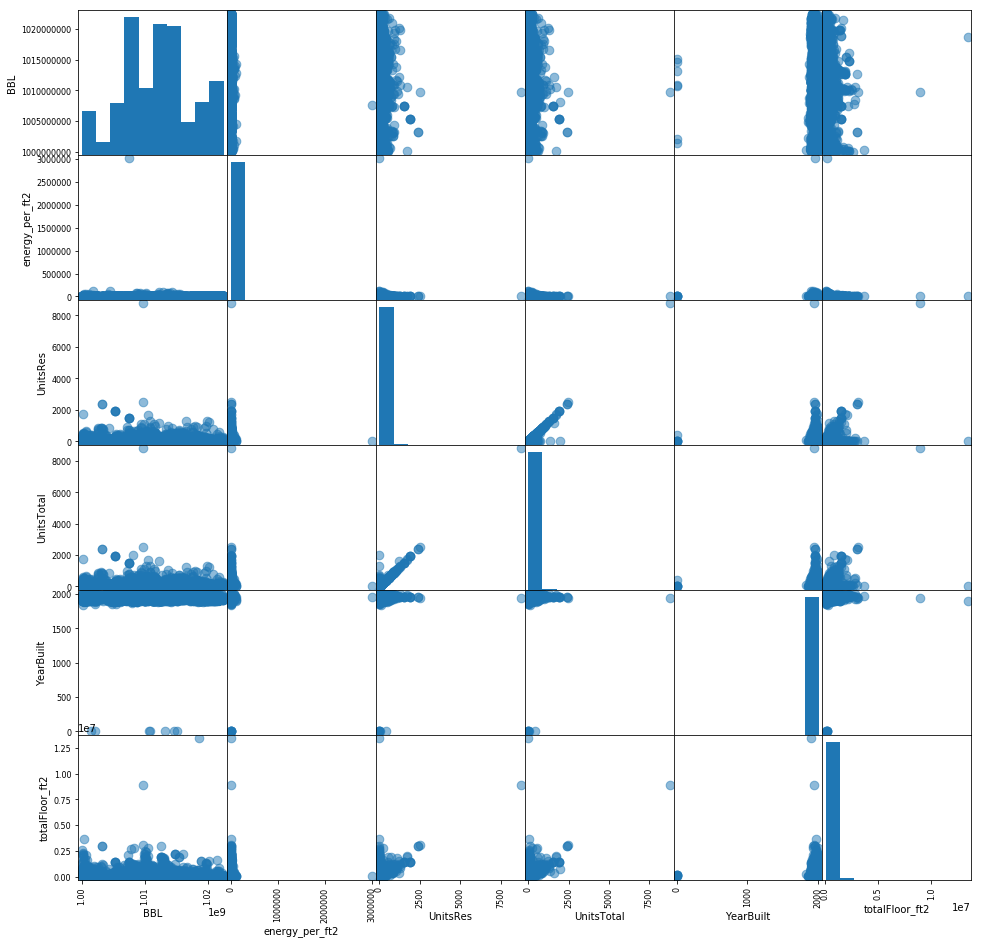

In [60]:
scatter_matrix (bblnrgdata, s=300, figsize=(16, 16));

### Figure 2: 

Bi-variable plot between key columns including # of Residence, total # of units, and Built Year. There are a few interesting preliminary insights:

- building built later in the years use more energy
- building with more floors use more energy
- building built later in the years have higher floors

In [61]:
bblnrgdata["totalEnergy"] = bblnrgdata["energy_per_ft2"] * bblnrgdata["totalFloor_ft2"]

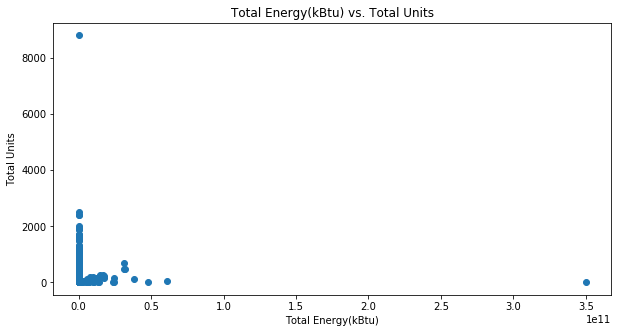

In [75]:
fig = pl.figure(figsize=(10,5));
ax = fig.add_subplot(111);
pl.plot(bblnrgdata.totalEnergy, bblnrgdata.UnitsTotal, "o");
pl.title("Total Energy(kBtu) vs. Total Units");
pl.xlabel("Total Energy(kBtu)");
pl.ylabel("Total Units");

### Figure 3: 

Scatter plot between Total Energy (kBtu) and Total Units. The graph is skewed due to some outliers. But there seem to be some relationship near energy range between 0-1e11 and units between 0-1000.

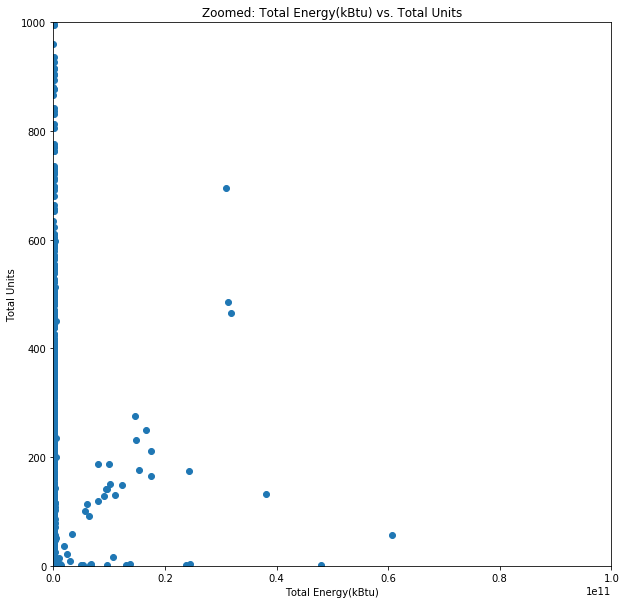

In [76]:
fig = pl.figure(figsize=(10,10));
ax = fig.add_subplot(111);
pl.plot(bblnrgdata.totalEnergy, bblnrgdata.UnitsTotal, "o");
ax.set_xlim([0, 1e11])
ax.set_ylim([0, 1000])
pl.title("Zoomed: Total Energy(kBtu) vs. Total Units");
pl.xlabel("Total Energy(kBtu)");
pl.ylabel("Total Units");

### Figure 4: 

Zoomed-in scatter plot between Total Energy (kBtu) from 0 to 1e11 and Total Units from 0-1000. There is a clear relationship between total energy use and number of floors. 

In [77]:
bblnrgdata.totalEnergy.describe()

count    4.694000e+03
mean     2.243964e+08
std      5.419760e+09
min      0.000000e+00
25%      5.896051e+06
50%      9.428502e+06
75%      1.907546e+07
max      3.501452e+11
Name: totalEnergy, dtype: float64

In [78]:
bblnrgdata.UnitsTotal.describe()

count    4694.000000
mean      111.438858
std       210.232746
min         0.000000
25%        27.000000
50%        65.000000
75%       125.750000
max      8805.000000
Name: UnitsTotal, dtype: float64

### Data Preprocessing and Log Transformation

In [108]:
bblnrgdata = bblnrgdata[(bblnrgdata.totalEnergy > 0) & (bblnrgdata.UnitsTotal >=10) & (bblnrgdata.UnitsTotal < 1000)]
bblnrgdata["log_totalEnergy"] = np.log10(bblnrgdata.totalEnergy)
bblnrgdata["log_unitsTotal"] = np.log10(bblnrgdata.UnitsTotal)

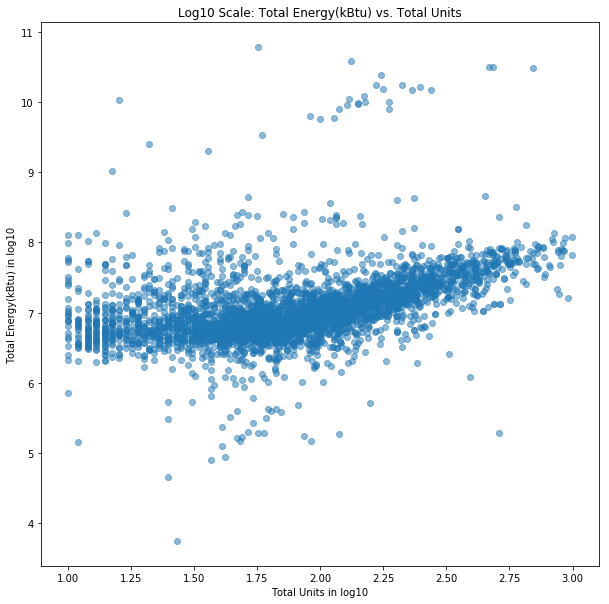

In [114]:
x = bblnrgdata.log_unitsTotal
y = bblnrgdata.log_totalEnergy

fig = pl.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, alpha = 0.5);

pl.title("Log10 Scale: Total Energy(kBtu) vs. Total Units");
pl.ylabel("Total Energy(kBtu) in log10");
pl.xlabel("Total Units in log10");

### Figure 5: 

Total Units vs. Total Energy (kBtu) in log scale. There is a clear linear relationship in the log space.

---

### Fit a line to Total Unit vs. Total Energy

In [115]:
X = sm.add_constant(x)
linmodel = sm.OLS(y, X, missing='drop').fit()

print(linmodel.summary())

                            OLS Regression Results                            
Dep. Variable:        log_totalEnergy   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     874.9
Date:                Sat, 21 Oct 2017   Prob (F-statistic):          4.80e-174
Time:                        14:28:06   Log-Likelihood:                -2358.9
No. Observations:                3996   AIC:                             4722.
Df Residuals:                    3994   BIC:                             4734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              6.0559      0.034    179.

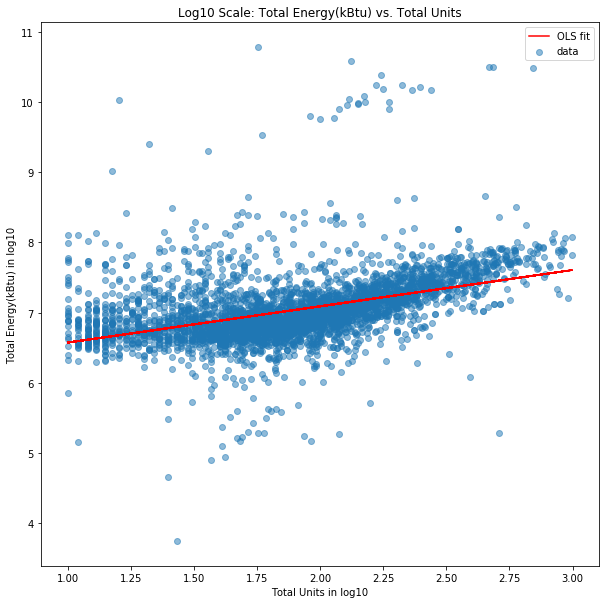

In [119]:
fig = pl.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, alpha = 0.5, label = "data");
ax.plot(x, linmodel.fittedvalues, 'r-', label = "OLS fit");

pl.title("Log10 Scale: Total Energy(kBtu) vs. Total Units");
pl.ylabel("Total Energy(kBtu) in log10");
pl.xlabel("Total Units in log10");
ax.legend(loc = "best");

### Figure 6

This is a scatter plot of Total Unit and Total Energy in log10 scale, with highlight of a OLS fit. 

---

### Fit a line to Total Energy vs. Total Units (switch the Depend and Independent Variables)

In [124]:
x = bblnrgdata.log_totalEnergy
y = bblnrgdata.log_unitsTotal
X = sm.add_constant(x)
linmodel2 = sm.OLS(y, X, missing='drop').fit()

print(linmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:         log_unitsTotal   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     874.9
Date:                Sat, 21 Oct 2017   Prob (F-statistic):          4.80e-174
Time:                        14:44:32   Log-Likelihood:                -1564.8
No. Observations:                3996   AIC:                             3134.
Df Residuals:                    3994   BIC:                             3146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              -0.5520      0.083     

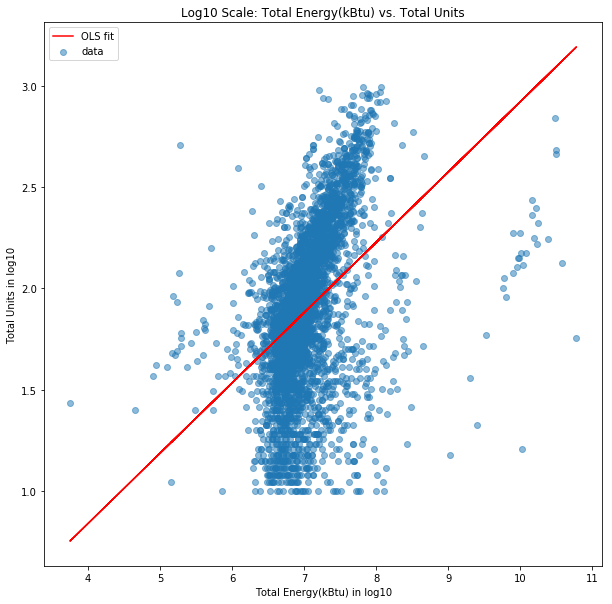

In [123]:
fig = pl.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, alpha = 0.5, label = "data");
ax.plot(x, linmodel2.fittedvalues, 'r-', label = "OLS fit");

pl.title("Log10 Scale: Total Energy(kBtu) vs. Total Units");
pl.xlabel("Total Energy(kBtu) in log10");
pl.ylabel("Total Units in log10");
ax.legend(loc = "best");

### Figure 7

This is a scatter plot of Total Energy vs. Total Unit  in log10 scale, with highlight of a OLS fit. 

---

### Chi Test of Two Scenario

- Independent variable = Total Unit
- Independent variable = Total Energy

In [125]:
# Error assuming Poisson Distribution
errorsunits = np.sqrt(bblnrgdata.UnitsTotal)
errorsnrg = np.sqrt((bblnrgdata['totalFloor_ft2'])**2 +\
                (bblnrgdata['energy_per_ft2']**2))

In [127]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdata.totalEnergy / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdata.UnitsTotal / np.log(10))

bblnrgdata['errorsnrg'] = errorsInLogNrg
bblnrgdata['errorsunits'] = errorsInLogUnits

In [128]:
bblnrgdata.sample(10)

,BBL,energy_per_ft2,UnitsRes,UnitsTotal,YearBuilt,totalFloor_ft2,totalEnergy,log_totalEnergy,log_unitsTotal,errorsnrg,errorsunits
2067,1.012360e+09,62.8,74,79,1924,164530.0,10332484.0,7.014205,1.897627,0.006916,0.048862
1781,1.011290e+09,64.1,100,102,1928,162676.0,10427531.6,7.018182,2.008600,0.006775,0.043002
3076,1.014870e+09,122.0,102,102,1964,81000.0,9882000.0,6.994845,2.008600,0.003560,0.043002
4027,1.021350e+09,123.0,53,53,1920,65256.0,8026488.0,6.904526,1.724276,0.003531,0.059655
455,1.005458e+09,60.2,52,54,1930,107754.0,6486790.8,6.812030,1.732394,0.007214,0.059100
5096,1.011398e+09,49.5,271,276,1992,701953.0,34746673.5,7.540913,2.440909,0.008774,0.026141
4222,1.021750e+09,49.5,68,74,1920,58400.0,2890800.0,6.461018,1.869232,0.008774,0.050486
4432,1.009970e+09,66.7,0,66,1988,426056.0,28417935.2,7.453593,1.819544,0.006511,0.053458
251,1.001970e+09,62.4,0,17,1928,56700.0,3538080.0,6.548768,1.230449,0.006960,0.105332
3373,1.015640e+09,53.4,192,200,1962,207546.0,11082956.4,7.044656,2.301030,0.008133,0.030709


In [129]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [141]:
score = chi2(bblnrgdata.log_unitsTotal, linmodel2.fittedvalues, errorsunits)

print("Using Total Energy as IV to Predict Number of Units has a CHI score: %.3f" % score)

Using Total Energy as IV to Predict Number of Units has a CHI score: 17.181


In [140]:
score = chi2(bblnrgdata.log_totalEnergy, linmodel.fittedvalues, errorsnrg)

print("Using Number of Unit as IV to Predict Energy has a CHI score: %.3f" % score)

Using Number of Unit as IV to Predict Energy has a CHI score: 0.000


### NULL Hypothesis of Chi Test

The observed value is the same as the predicted value using a OLS model.

### Observation

1) Using Total Energy as the Independant Variable to predict Number of Unit has a very high Chi Score (17.18). This means we can reject the hypothesis that the actual observed value is the same as the prediction. In other words, the observed energy consumption based on number of unit is different from the predicted value (the error is large). 

2) In contrast, when we use the number of unit to predict total energy, the chi score is close to 0. This means the observed and predicted energy consumption is similar as the NULL hypothesis stands. 

Therefore, using the Number of Units as Independent Variable provide better model results.

We cannot use likelihood-ratio test in this case because the two model are not nested (they are in the same order, y = ax+b).

---

### Likelihood Ratio Test

In [173]:
# Create a x^2 term

bblnrgdata["log_unitsTotal_sq"] = bblnrgdata["log_unitsTotal"] * bblnrgdata["log_unitsTotal"]

In [167]:
linmodel = smf.ols(formula = "log_totalEnergy ~ log_unitsTotal", 
                     data = bblnrgdata).fit() 

linmodel_sq = smf.ols(formula = "log_totalEnergy ~ log_unitsTotal_sq + log_unitsTotal", 
                     data = bblnrgdata).fit()

In [168]:
print(linmodel.summary())

                            OLS Regression Results                            
Dep. Variable:        log_totalEnergy   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     874.9
Date:                Sat, 21 Oct 2017   Prob (F-statistic):          4.80e-174
Time:                        16:44:17   Log-Likelihood:                -2358.9
No. Observations:                3996   AIC:                             4722.
Df Residuals:                    3994   BIC:                             4734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.0559      0.034    179.

In [169]:
print(linmodel_sq.summary())

                            OLS Regression Results                            
Dep. Variable:        log_totalEnergy   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     637.7
Date:                Sat, 21 Oct 2017   Prob (F-statistic):          4.77e-241
Time:                        16:44:20   Log-Likelihood:                -2200.9
No. Observations:                3996   AIC:                             4408.
Df Residuals:                    3993   BIC:                             4427.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             8.0706      0.11

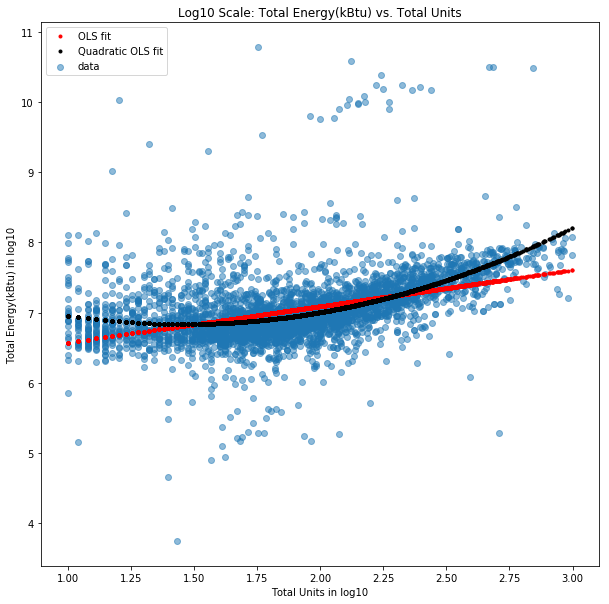

In [181]:
x = bblnrgdata.log_unitsTotal
y = bblnrgdata.log_totalEnergy

fig = pl.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, alpha = 0.5, label = "data");
ax.plot(x, linmodel.fittedvalues, 'r.', label = "OLS fit");
ax.plot(x, linmodel_sq.fittedvalues, 'k.', label = "Quadratic OLS fit");

pl.title("Log10 Scale: Total Energy(kBtu) vs. Total Units");
pl.ylabel("Total Energy(kBtu) in log10");
pl.xlabel("Total Units in log10");
ax.legend(loc = "best");

In [183]:
print("Likelihood Ratio: %.3f" %(linmodel_sq.compare_lr_test(linmodel)[0]))

Likelihood Ratio: 316.025


### Obersvation

The likelihood between the quadratic OLS vs. linear OLS is larger than 3.84, which is the threshold for Chi Test at 95% confidence level. This means that the NULL hypothesis of the quadratic and linear OLS performance are the same can be rejected.

In other words, the quadradic OLS is a better model in this case.